In [83]:
import numpy as np
import ode
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

The equation of motion for a knuckleball has the form: $$C_L(\theta) = a_0 \sin(4\theta - \pi) + a_1 \sum_{i=1}^{n} \Big[\sin(\frac{||\mathbf{s_i}-\mathbf{p}||\pi}{2d} + \pi/2)\cdot \text{sgn}(p^{*}-s_{i}^{*})\Big].$$

Here, $\theta$ is the angle of attack on the ball. The first term accounts for vortex shedding *look up what this is*, and the second accounts for forces produced by the baseball's seams. 

1.0065286881157438

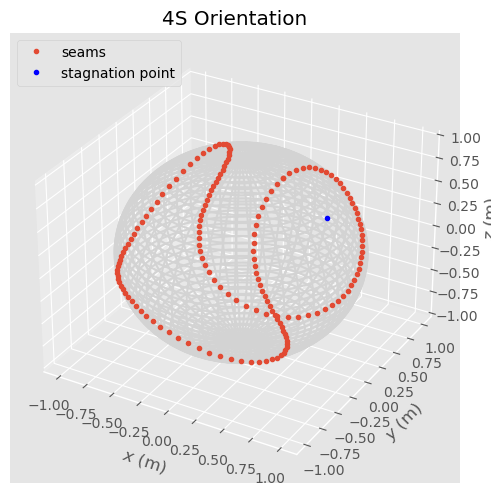

In [84]:
# alpha = np.linspace(1,6,162)
alpha = np.linspace(0,2*np.pi,162)
B = 0.6
F = 1
R = 1
# unnormalized points
xu = np.cos(alpha) - B*np.cos(3*alpha)
yu = np.sin(alpha) + B*np.sin(3*alpha)
zu = F*np.cos(2*alpha)

ru_squared = 1 + B**2 + (F**2-2*B)*(np.cos(2*alpha))**2 + 2*B*(np.sin(2*alpha))**2
ru = np.sqrt(ru_squared)

x = R * xu/ru
y = R * yu/ru
z = R * zu/ru

# draw baseball
u = np.linspace(0, np.pi, 100)
v = np.linspace(0, 2 * np.pi, 100)
x_ball = np.outer(np.sin(u), np.sin(v))
y_ball = np.outer(np.sin(u), np.cos(v))
z_ball = np.outer(np.cos(u), np.ones_like(v))
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(x_ball, y_ball, z_ball,color='lightgray')
ax.plot(x, y, z, '.', label='seams')

#plot stagnation point
stag_x = 0.91
stag_y = 0.35
stag_z = 0.25
ax.plot(0.5,0.5,0.25,'.',color='blue',label = 'stagnation point')

ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
ax.set_zlabel("$z$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()
# # fig.savefig("baseball.png")
ax.set_title('4S Orientation')
np.sqrt(stag_x**2+stag_y**2+stag_z**2) #checking that the stagnation point is on the surface of the sphere

In [93]:
def C_L_knuckleball(S):
    theta = S
    # vortex shedding term:
    t1 = a0*np.sin(4*theta - np.pi)
    
    # seam term:
    dist_seam = np.zeros(alpha.shape[0])
    s_star = np.zeros(alpha.shape[0])
    for s_i in range(alpha.shape[0]):
        dist_seam[s_i] = np.sqrt((x[s_i]-stag_x)**2 + (y[s_i]-stag_y)**2 + (z[s_i]-stag_z)**2)
        s_star = z[s_i]
    d = 2 * R # ball diameter
    a1 = 0.0062

    t2 = a1*np.sum(((np.sin((np.linalg.norm(dist_seam)*np.pi / (2*d) + np.pi/2) * np.sign(stag_z - s_star)))))
    return t1 + t2
    

# #vortex shedding term: 
# theta = np.pi/3
# t1 = a0*np.sin(4*theta - np.pi)

# # seam term
# dist_seam = np.zeros(alpha.shape[0])
# s_star = np.zeros(alpha.shape[0])
# for s_i in range(alpha.shape[0]):
#     dist_seam[s_i] = np.sqrt((x[s_i]-stag_x)**2 + (y[s_i]-stag_y)**2 + (z[s_i]-stag_z)**2)
#     s_star = z[s_i]
# d = 2 * R # ball diameter
# a1 = 0.0062

# t2 = a1*np.sum(((np.sin((np.linalg.norm(dist_seam)*np.pi / (2*d) + np.pi/2) * np.sign(stag_z - s_star)))))

In [88]:
C_L = t1 + t2
C_L

0.05503873238606107

In [101]:
# simple baseball:  

def C_L(S):
    return 0.62 * S**0.7

def simulate_baseball(v0, omega, r0=None,
                      h=0.01, C_D=0.40, g=9.81, rho=1.225,
                      r=0.07468/2, m=0.14883,
                      R_homeplate=18.4,knuckleball=False):
    """simulate baseball pitch
    
    Parameters
    ----------
    v0 : array
         initial velocity (vx, vy, vz) in m/s
    omega : array
         angular velocity vector of the ball ("spin"), in rad/s
    r0 : array, optional
         initial position of the ball (in m) when it leaves the pitcher's hand
         as (x, y, z); the default is (0, 2, 0)
    h : float, optional
         integration time step in s, default is 0.01 s
    C_D : float, optional
         drag coefficient, default is 0.40
    g : float, optional
         acceleration due to gravity, default 9.81 kg/(m*s^2)
    rho : float, optional
         density of air, default 1.225 kg/m^3
    r : float, optional
         radius of the baseball
    m : float, optional
         mass of the baseball
    R_homeplate : float, optional
         distance of the catcher from the pitcher
         
    Returns
    -------
    
    positions : array
         The array contains an entry (time, x, y, z) for each time step.
    """
    # all SI units (kg, m)
    if r0 is None:
        r0 = np.array([0, 2.0, 0])  # pitching at 2m height
    
    omega = np.asarray(omega)
        
    domega = np.linalg.norm(omega)
    A = np.pi*r**2
    rhoArm = rho * A * r / m
    b2 = 0.5 * C_D * rho * A
    
    a_gravity = np.array([0, -g, 0])

    def f(t, y):
        # y = [x, y, z, vx, vy, vz]
        v = y[3:]
        dv = np.linalg.norm(v)
        S = r*domega/dv
        if knuckleball:
            a_magnus = 0.5 * C_L_knuckleball(S) * rhoArm / S * np.cross(omega, v)
        else:
            a_magnus = 0.5 * C_L(S) * rhoArm / S * np.cross(omega, v)
#         print(a_magnus)
        a_drag = -b2/m * dv * v
        a = a_gravity + a_drag + a_magnus
        return np.array([y[3], y[4], y[5],
                         a[0], a[1], a[2]])

    t = 0
    # initialize 3D!
    y = np.array([r0[0], r0[1], r0[2], v0[0], v0[1], v0[2]], dtype=np.float64)
    positions = [[t, y[0], y[1], y[2]]] # record t, x and y, z
    
    while y[0] < R_homeplate and y[1] >= 0.2:
        t += h
        y[:] = ode.rk4(y, f, t, h)
        positions.append([t, y[0], y[1], y[2]])  # record t, x and y, z
        
    return np.array(positions)

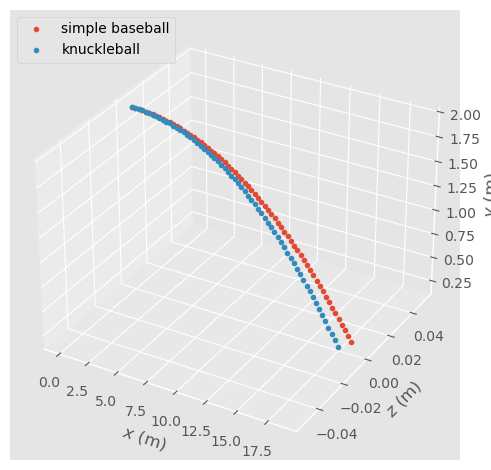

In [109]:
r = simulate_baseball([30, 0, 0], omega=50 * np.array([0,0,1]))
r2 = simulate_baseball([30, 0, 0], omega=50 * np.array([0,0,1]),knuckleball=True)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:,1], r[:,3], r[:,2], '.', label="simple baseball")
ax.plot(r2[:,1],r2[:,3],r2[:,2],'.',label='knuckleball')
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$z$ (m)")
ax.set_zlabel("$y$ (m)")
ax.legend(loc="upper left", numpoints=1)
ax.figure.tight_layout()
# fig.savefig("baseball.png")